<center><h2>Pulsars Classification Using HTRU Survey</h2></center>

<center><h3>By: Jorge Cárdenas</h3></center>

<center><h5>University of Antioquia, MSc in Physics</h5></center>

<center><img src="images/Pulsar_ML_V1.jpeg" width="400" height="200"></center>


In [25]:
from IPython.display import Image
from IPython.display import HTML, display
from IPython.core.magic import register_cell_magic

@register_cell_magic
def background(color, cell):
    set_background(color)
    return eval(cell)

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy import special


from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


from IPython.display import display

%matplotlib inline

# Data Exploration
Data provided by the High Time Resolution Universe Pulsar Survey (HTRU), includes the some variables that describe de geometry of the detected pulses, and based on their profile one can infer how to catalogue the candidates.

# Profiles

<center><img src="images/pulse1.png" width="400" height="500"></center>
<center><h5>Figure 1. Example of the folding to obtain and integrated profile presented at the bottom.</h5></center>

### ***Profile Integration***
<a id='section1'></a>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">The integrated profile of a radio source is the final goal of the detection process for pulsars. 
There are many difficulties to obtain such profile, i.e. disperssion measure and noise, but the process has been refined to such level of getting a survey with thousands of potential candidates to pulsar.</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Now, once the profile is obtained, we can consider it as a "signature" of a radio source describing how the shape of the profile is behaving and if the candidate is or is not a pulsar. The selection process has been mainly done "by hand" but as the number of candidates increases, so increases the difficulty to rule out the pulsar candidate.</p>

### ***Dataset fields***
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">The survey provides labeled data identifying for radio sources that are unequivocally identified as pulsars and the ones that are not.</p>

#### Skewness and Kurtosis
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Skewness and kurtosis are the features that can be used to characterize a given integrated profile.
</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Skewness is a measure of the lack of symmetry, by being more concentrated on one side than the other of the distribution or profile.
</p>
<center><img src="images/nfg005.gif" width="400" height="200"></center>
<br>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Kurtosis is a measure of the heaviness of the tails in comparison with a normal distribution. 
</p>

<center><img src="images/kurtosis.png" width="400" height="200"></center>

#### Features

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Pulsars are characterized by some general rules: profile narrowing with frequency, outer components are more pronounced with frequency, 
</p>
<br>
<br>

|Name                          |Description                         |
|-------------------------------|-----------------------------|
|`Mean of the integrated profile`|Mean value of the profile.           |
|`Standard deviation of the integrated profile`|Standard deviation of the profile  |
|`Excess kurtosis of the integrated profile`|Describes the peakness of the integrated profile.|
|`Skewness of the integrated profile`|Left or right heaviness of the integrated profile.|
|`Mean of the DM-SNR curve`|Mean of the Disperssion Measure - SRN curve.|
|`Standard deviation of the DM-SNR curve`|Mean of the Disperssion Measure - SRN curve.|
|`Excess kurtosis of the DM-SNR curve`|Standard deviation of the Disperssion Measure - SRN curve.|
|`Skewness of the DM-SNR curve`|Standard deviation of the Disperssion Measure - SRN curve.|
|`target_class`|label for pulsar candidate.|



In [2]:
data = pd.read_csv("pulsar_data_train.csv")
data_test = pd.read_csv("pulsar_data_test.csv")

In [3]:
data.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [4]:
data.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


In [5]:
data.dtypes

 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object

In [6]:
data.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [7]:
data.apply(lambda x : print(x.name+" Nulls: " + str(np.count_nonzero(x.isnull()))) )


 Mean of the integrated profile Nulls: 0
 Standard deviation of the integrated profile Nulls: 0
 Excess kurtosis of the integrated profile Nulls: 1735
 Skewness of the integrated profile Nulls: 0
 Mean of the DM-SNR curve Nulls: 0
 Standard deviation of the DM-SNR curve Nulls: 1178
 Excess kurtosis of the DM-SNR curve Nulls: 0
 Skewness of the DM-SNR curve Nulls: 625
target_class Nulls: 0


 Mean of the integrated profile                  None
 Standard deviation of the integrated profile    None
 Excess kurtosis of the integrated profile       None
 Skewness of the integrated profile              None
 Mean of the DM-SNR curve                        None
 Standard deviation of the DM-SNR curve          None
 Excess kurtosis of the DM-SNR curve             None
 Skewness of the DM-SNR curve                    None
target_class                                     None
dtype: object

---
### **Correlation**

<p style="font-family:verdana;color:#34495E;font-size:0.9em;">Here we can explore how variables relate to each other using a correlation matrix.</p>
<br>

#### ***Conclusions***

1. Based on the following plot, data is very unbalanced. That characteristic can introduce bias and undesireable behaviors during the training process.

2. Data has important correlations:
    - Skewness and the mean of the integrated profile 
    - there are two features set: the one of the integrated profile and the one of the DM-SNR. Both provide different and uncorrelated information. 
    - There is a very important relation between the skewness of the integrated profile and the Excess Kurtois of the DM curve.

In [8]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Figure 2. Correlation Matrix for {filename}', fontsize=10)
    plt.show()

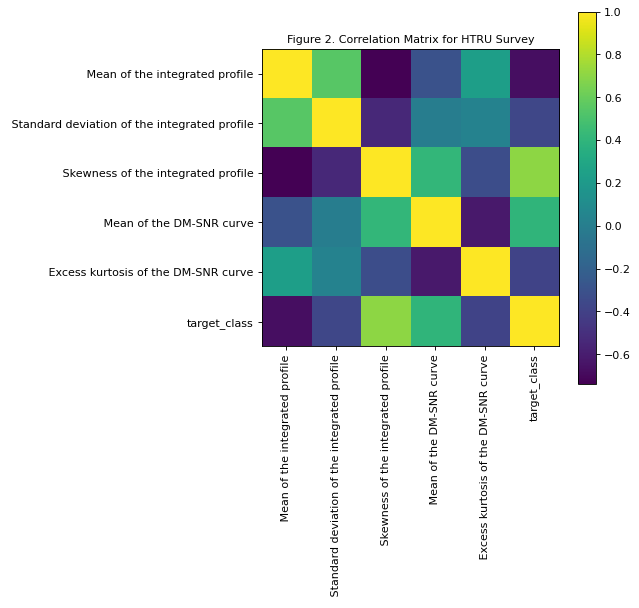

In [9]:
data.dataframeName = 'HTRU Survey'
plotCorrelationMatrix(data, 6)

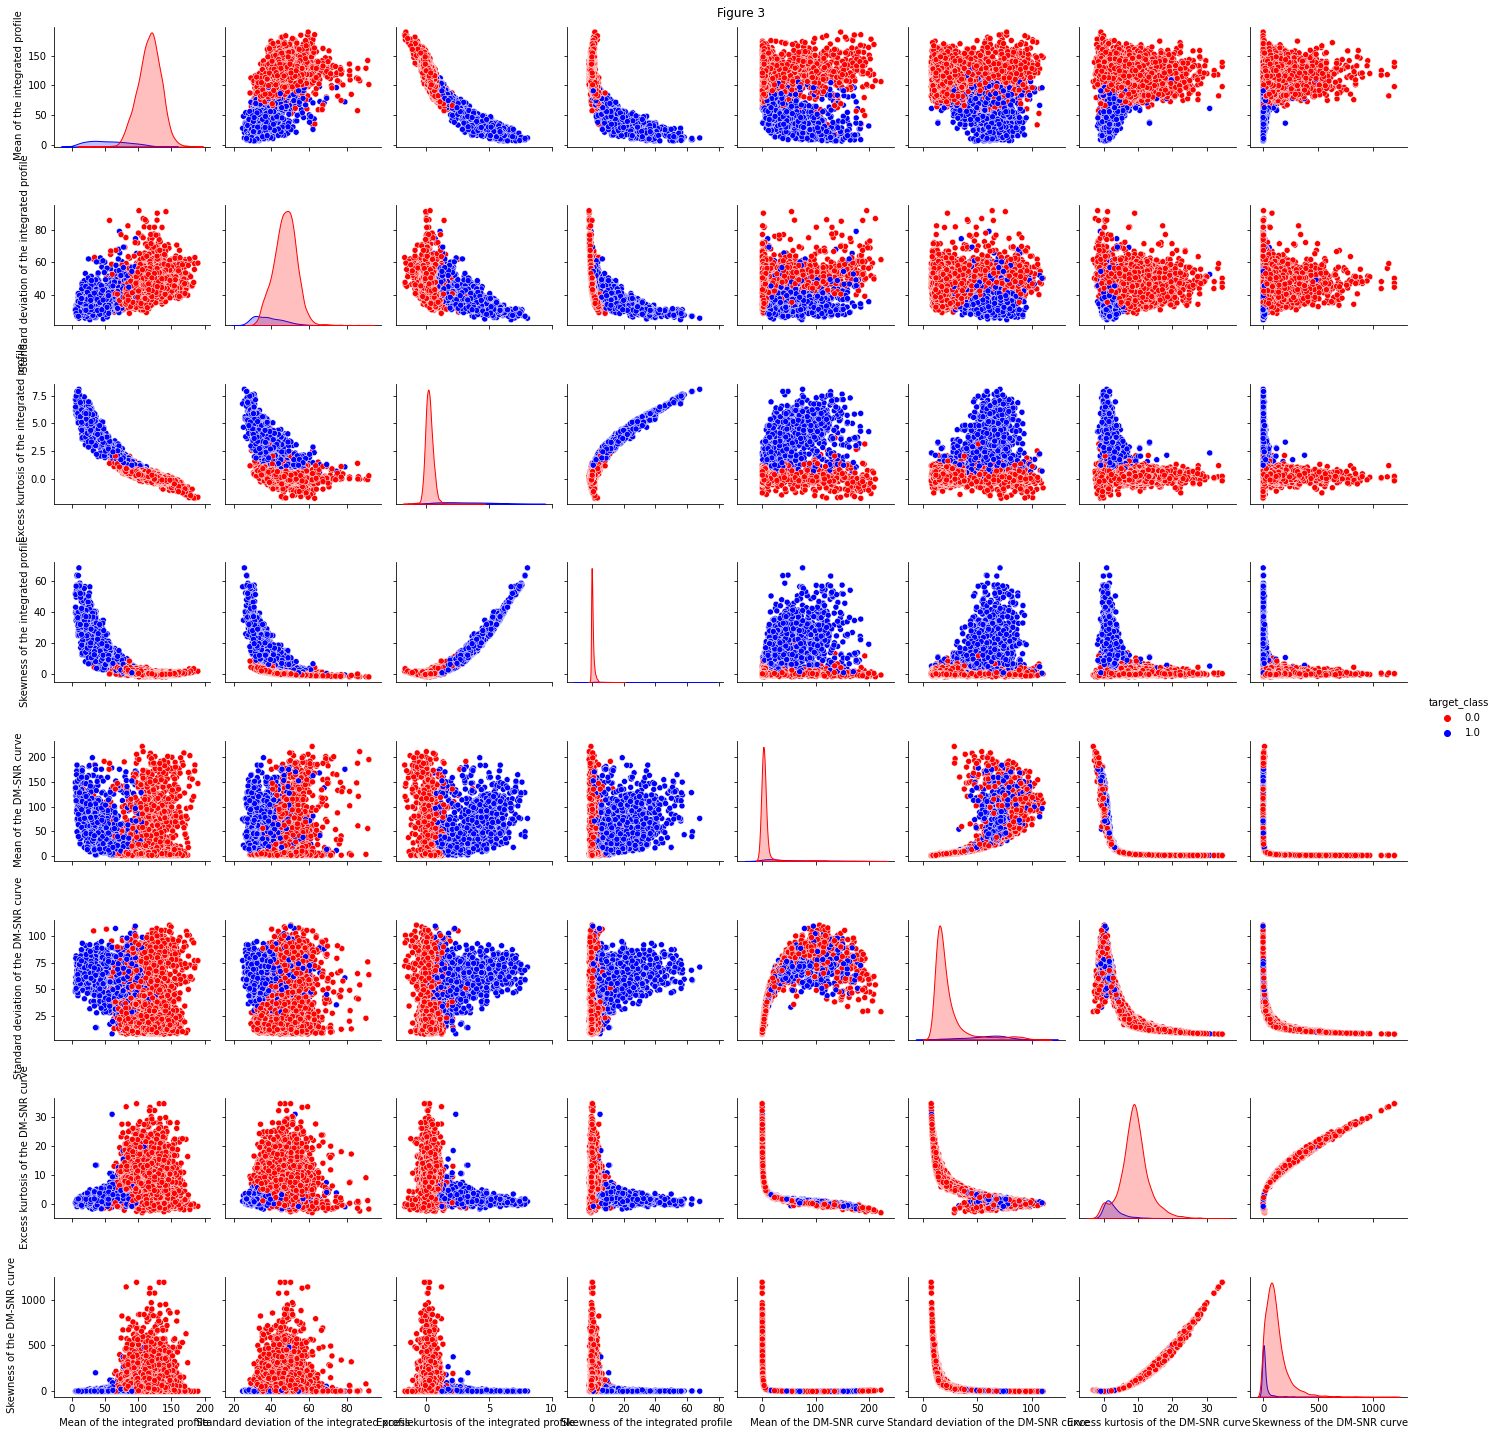

In [12]:

g = sns.pairplot(data, hue="target_class", palette=["red","blue"])
g.fig.suptitle("Figure 3", y=1) 
g.fig.savefig('images/pairplot_umblanaced.png')


---
# Preprocessing


In this particular case, we are facing a classification problem, in order to separate data in two categories: pulsar or non-pulsar.


## Model 1: Exploratory Decision Tree Classifier


### ***Feature***


 - One of the first measures was to drop all rows containing NAN values. This is a brute force action that justifies using different strategies to impute data in the next sections.

In [13]:
from sklearn import tree

features = data.copy()

features = features.dropna('columns')
target = features[['target_class']]
features.drop('target_class', axis=1, inplace=True)

y=target

xtrain,xval,ytrain,yval=train_test_split(features,list(y['target_class']),test_size=0.1,random_state=42)

model=tree.DecisionTreeClassifier()
clf = model.fit(xtrain,ytrain)

pred=model.predict(xval)

print(f'Accuracy of the model is (%):')
display(accuracy_score(yval,pred)*100)

Accuracy of the model is (%):


96.0095770151636

In [14]:
df_test = data_test.dropna('columns')
target=model.predict(df_test)


In [15]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=features.columns,
                                class_names='target_class', filled=True, rounded=True,  special_characters=True)   
graph = graphviz.Source(dot_data)
graph.render('tree') 

'tree.pdf'

### ***Imputing data and preparation***


A more interesting approach is to:

    
    
    
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;"> Normalize the data frame:</span>  We have different values y sizes of values and the best performance come when we normalize data with respect to the data frame. 
</p>
    
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;"> Impute Data:</span>  As has been seen, data is unbalanced what could create bias and probles during training. We can trying a different approach instead just removing NAN fields in the dataframe. 
</p>



In [16]:
#Display the nulls in the data frame
data.apply(lambda x : print(x.name+" Nulls: " + str(np.count_nonzero(x.isnull()))) )
df = data.fillna(data.mean())


 Mean of the integrated profile Nulls: 0
 Standard deviation of the integrated profile Nulls: 0
 Excess kurtosis of the integrated profile Nulls: 1735
 Skewness of the integrated profile Nulls: 0
 Mean of the DM-SNR curve Nulls: 0
 Standard deviation of the DM-SNR curve Nulls: 1178
 Excess kurtosis of the DM-SNR curve Nulls: 0
 Skewness of the DM-SNR curve Nulls: 625
target_class Nulls: 0


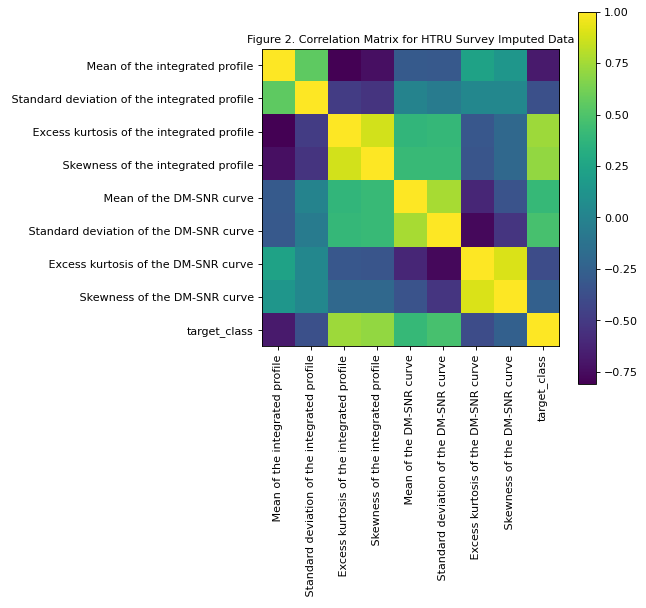

In [17]:
df.dataframeName = 'HTRU Survey Imputed Data'
plotCorrelationMatrix(df, 6)

     
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;"> Impute Data:</span> After imputing data, it is more clear there are meaningul relations between variables. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>  There is correlation between Excess Kurtosis and Skewness of the integrated profile and the target class. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>  There is also a meaningfull correlation between DM-SNR STd deviaton, Mean and the target class. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>  In any case, there is a hight correlation between skewness and kurtosis. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>  A high negative correlation is present between Mean of the integrated profile and the target class. </p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li>  Also, there is a negative correlation between the mean of the integrated profile and skewness and kurtosis. </p>


### ***Standardization***


Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance

\begin{equation}
z= \frac{x_i-\mu}{\sigma}
\end{equation}



In [18]:
df = data.fillna(data.mean())

target = df[['target_class']]
df.drop('target_class', axis=1, inplace=True)

scaler = preprocessing.StandardScaler().fit(df)


In [19]:
X_scaled = scaler.transform(df)
X_scaled

array([[ 0.39398903,  0.27225212, -0.10429478, ..., -0.4260294 ,
        -0.19481754, -0.3856108 ],
       [-1.32725743, -1.52127273,  0.2371508 , ..., -0.47040968,
         0.23837256, -0.02677448],
       [ 0.76130595,  0.98636783, -0.34926418, ..., -0.2136999 ,
         0.038556  , -0.30085857],
       ...,
       [ 0.19435365, -0.48635278,  0.18711775, ..., -0.78880041,
         1.92294752,  1.97434795],
       [ 0.95911539,  0.50175114, -0.57528199, ..., -0.25983093,
        -0.20616758, -0.41259999],
       [ 0.37725131,  0.58093396, -0.1339516 , ..., -0.77998976,
         2.05677923,  2.14002784]])

---
## Model 2: Exploratory Random Forest with Imputed Data and Standardized Dataset


     
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;"> Is there any improvement when processing data?</span> Here we evaluat the same Random Forest Model, but instead of removing NAN rows from dataset, we just treat them by imputing data and standardizing the data frame. </p>

In [20]:
y=target

X_train, X_test, y_train, y_test = train_test_split(X_scaled,list(y['target_class']), test_size=0.2)

model=RandomForestClassifier(max_depth=2,random_state=0)
model.fit(X_train,y_train)

pred=model.predict(X_test)



print(f'Accuracy of the model is (%):')
display(accuracy_score(y_test,pred)*100)


Accuracy of the model is (%):


97.28651237031126

---
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;"> Plot predicted sample:</span> Here we present the results of prediction against the training data (red and blue) </p>

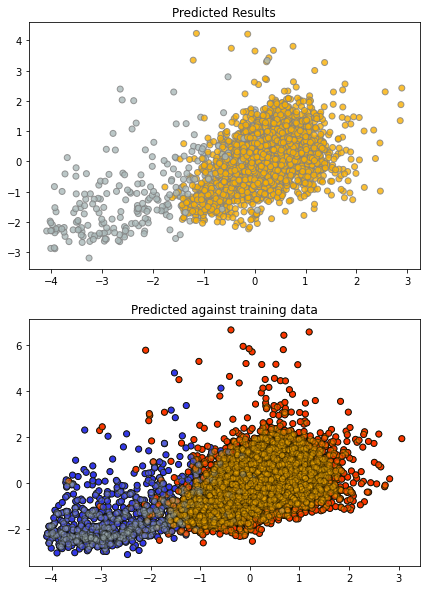

In [21]:
# Plot the training points
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cm_bright2 = ListedColormap(["#FBB000", "#AABABA"])

f, axes = plt.subplots(2,figsize=(7,10))

axes[0].set_title('Predicted Results')
axes[0].scatter(
    X_test[:, 0], X_test[:, 1], c=list(y_test), cmap=cm_bright2, alpha=0.8, edgecolors="gray"
)


axes[1].set_title('Predicted against training data')

axes[1].scatter(X_train[:, 0], X_train[:, 1], c=list(y_train), cmap=cm_bright, edgecolors="k")
# Plot the testing points
axes[1].scatter(
    X_train[:, 0], X_train[:, 1], c=list(y_train), cmap=cm_bright2, alpha=0.3, edgecolors="k"
)


f.savefig('images/comparative_classification.png')



---


# Model: Neural Network


In [48]:
!pip install tensorflow

In [22]:
from tensorflow import keras
import tensorflow as tf

# example of a model defined with the sequential api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# define the model


### ***Neural Network***

    
<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Binary Classification:</span>  As the model is a binary classification, where we get a value for whether a candidate is pulsar or not, the final layer is a single neuron with SIGMOID activation function.
</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Activation function:</span>  The selected activation function is RElU, with 10 neurons in the first layer and 8 in the second. All layers are Fully Connected.
</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Neurons Weights Initialization Normal Distribution:</span>  It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
</p>

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Optimizer:</span>  We have to select what optimizer to use. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
</p>

- alpha. Also referred to as the learning rate or step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training.

- beta1. The exponential decay rate for the first moment estimates (e.g. 0.9).

- beta2. The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).

- epsilon. Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).

<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Loss function:</span>  The goal of loss function or cost function is to evaluate a candidate solution against a TRUTH value and to be minimized during the iterative process of training the Neural Network.
</p>
    
<center><img src="images/nn.png" width="500" height="300"></center>




In [23]:
n_features = X_scaled.shape[1]
model = Sequential()
model.add(Dense(15, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.008,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.BinaryCrossentropy()])


In [40]:
history = model.fit(np.asarray(X_train),np.asarray( y_train), epochs=800, batch_size=150, verbose=0)


In [41]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                135       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 306
Trainable params: 306
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
loss, acc, binary = model.evaluate(np.asarray(X_test), np.asarray(y_test), verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.970


In [43]:
df_test = data_test.fillna(data_test.mean())
df_test.drop('target_class', axis=1, inplace=True)

scaler = preprocessing.StandardScaler().fit(df_test)
X_test_scaled = scaler.transform(df_test)

In [44]:
np.asarray(X_test_scaled[0])

array([ 0.22405985,  0.33220941, -0.29855032, -0.30978205, -0.32378783,
       -0.47186654, -0.02504986, -0.23507716])

In [45]:
# make a prediction
yhat = model.predict(np.asarray(X_test_scaled))
yhat

array([[7.8066484e-11],
       [9.7784042e-01],
       [1.3533135e-13],
       ...,
       [2.9421806e-06],
       [1.5243491e-12],
       [2.3589882e-05]], dtype=float32)

In [46]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'binary_crossentropy'])


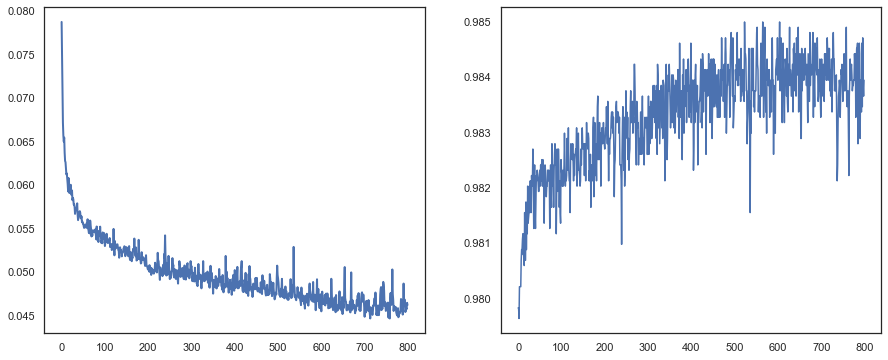

In [47]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

f, axes = plt.subplots(1,2,figsize=(15,6))

sns.color_palette("mako", as_cmap=True)
sns.lineplot(data = history.history['loss'],ax=axes[0],linewidth=2)

sns.lineplot(data = history.history['accuracy'],ax=axes[1])
plt.show()

f.savefig('images/initial_Accuracy.png')


<AxesSubplot:>

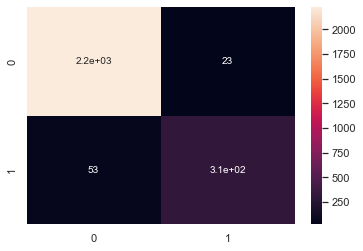

In [48]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(np.asarray(X_test))
y_pred = (y_pred>0.6)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True,annot_kws={"size": 10})

---
### ***Processing for Oversampling***


<p style="font-family:verdana;color:#34495E;font-size:0.9em;"><li> <span style="font-weight: bold;font-family:verdana;color:#34495E;font-size:0.9em;">Oversampling:</span>  As our database is very unblanced, we need to address this situation by adding more sinthetic data to the dataset or, on the ohter hand, removing data related to the target class with the highest number of samples.
</p>

In [32]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.8.1-py3-none-any.whl (189 kB)



<p style="font-family:verdana;color:#34495E;font-size:0.9em;"> Here we are adding synthetic data to augment the minority class, which in this case is the PULSAR=1 class.
    
</p>
<p style="font-family:verdana;color:#34495E;font-size:0.9em;">As can be seen in the figure, the "blue" class nos is more balance compared to the "red" one. You can also see the contrast when comparing to Figure 3.
    
</p>

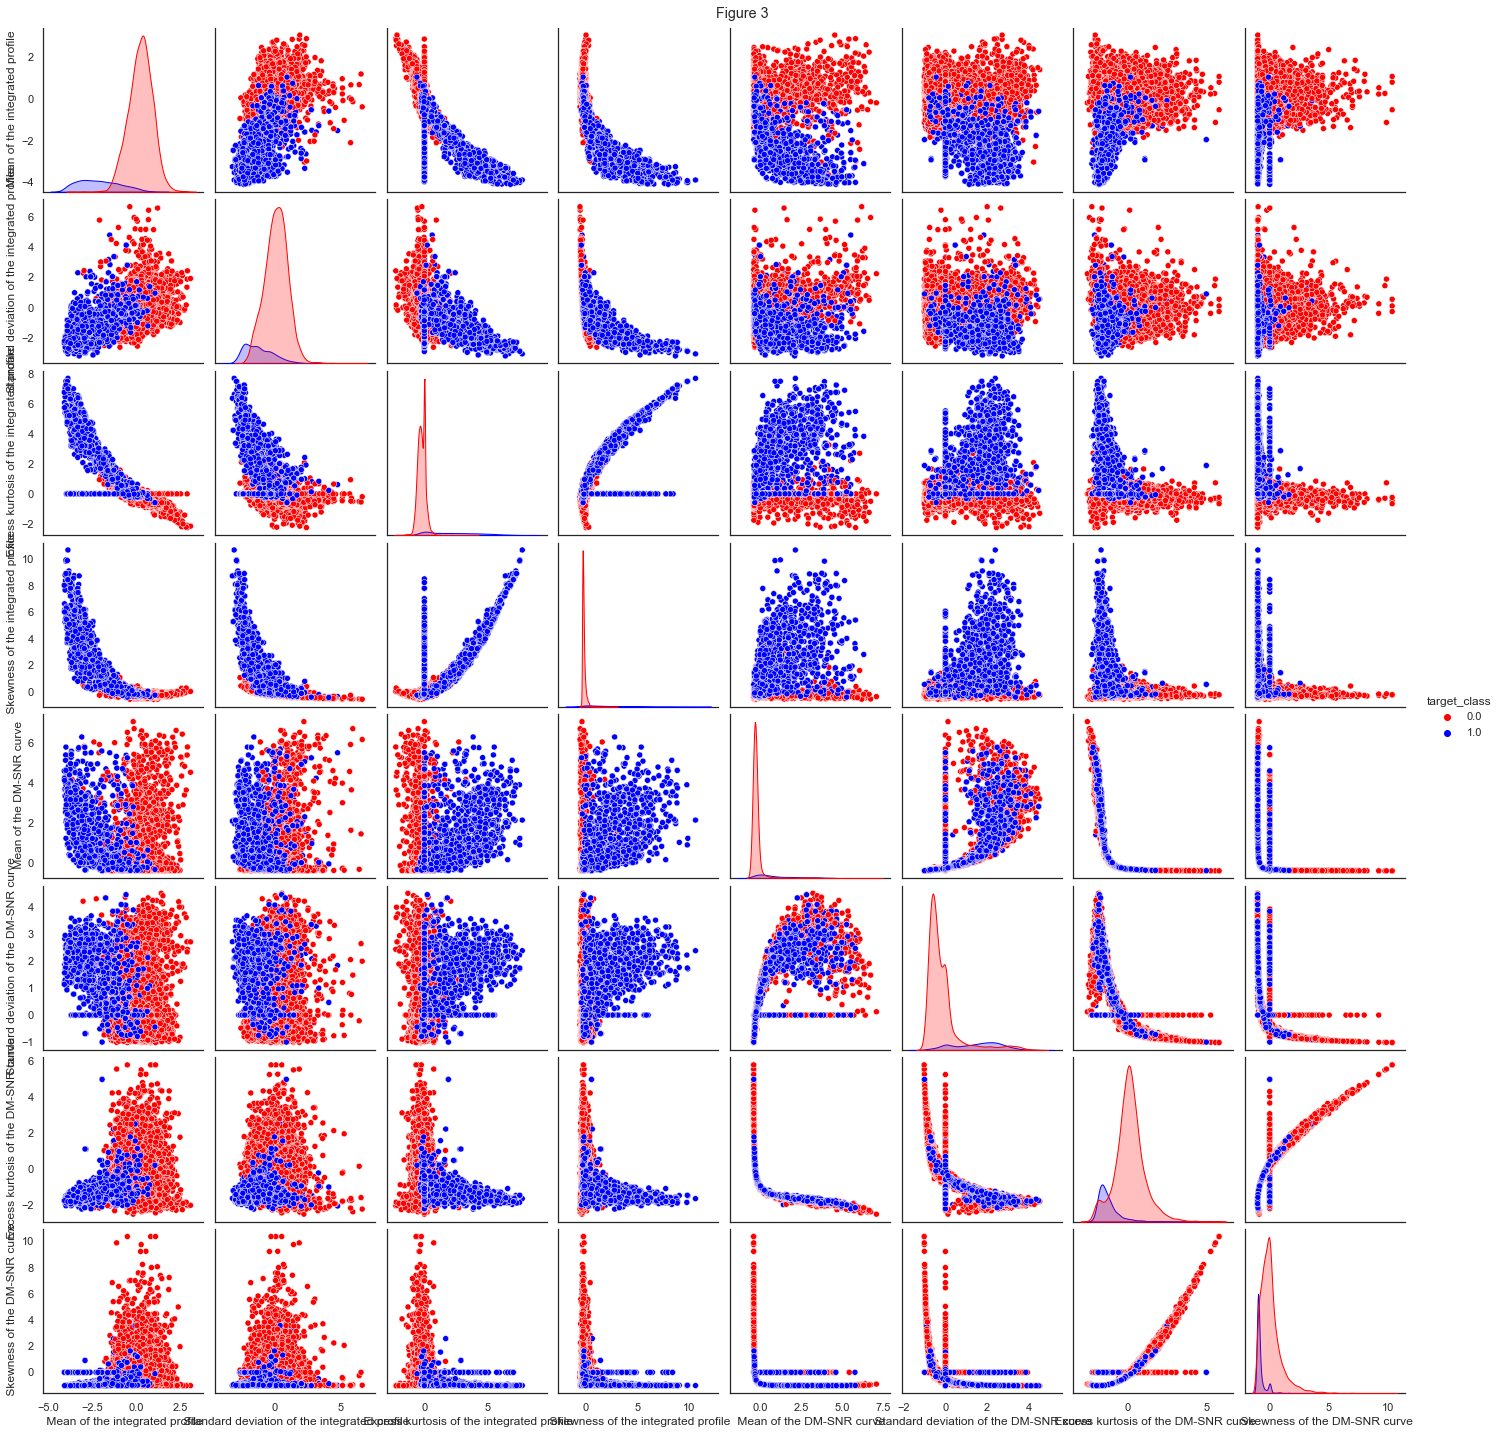

In [49]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=0.15) 
X_over, y_over = oversample.fit_resample(X_scaled, target)

df_1 = pd.DataFrame(data =X_over,columns=df.columns)
df_2 = pd.DataFrame(data =y_over,columns=['target_class'])

df_concat = pd.concat([df_1, df_2], axis=1)
df_concat


g = sns.pairplot(df_concat, hue="target_class", palette=["red","blue"])

g.fig.suptitle("Figure 3", y=1.0) 
g.fig.savefig('images/pairplot_2.png')


---

### ***Neural Network with Balanced Data***



In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

In [77]:
n_features = X_scaled.shape[1]
model_balanced = Sequential()
model_balanced.add(Dense(15, activation='relu', kernel_initializer='he_normal'))
model_balanced.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model_balanced.add(Dense(1, activation='sigmoid'))

In [78]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

model_balanced.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.BinaryCrossentropy()])


In [79]:
history = model_balanced.fit(np.asarray(X_train),np.asarray( y_train), epochs=800, batch_size=300, verbose=0)
loss, acc, binary = model_balanced.evaluate(np.asarray(X_test), np.asarray(y_test), verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.979


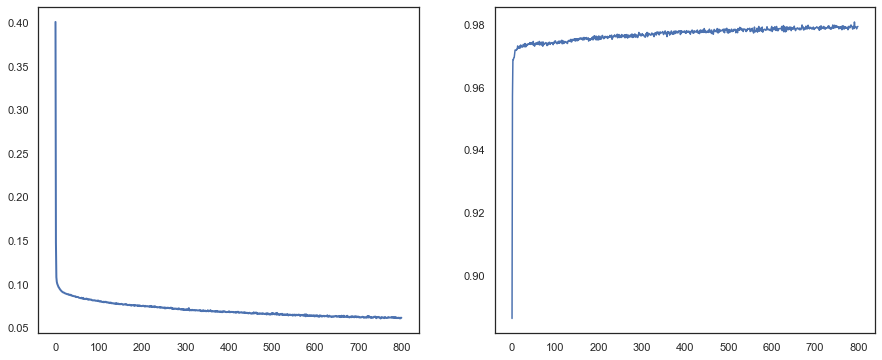

In [80]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

f, axes = plt.subplots(1,2,figsize=(15,6))

sns.color_palette("mako", as_cmap=True)
sns.lineplot(data = history.history['loss'],ax=axes[0],linewidth=2)
sns.lineplot(data = history.history['accuracy'],ax=axes[1])
plt.show()

f.savefig('images/improved_Accuracy.png')



# References

Archive.ics.uci.edu. 2021. UCI Machine Learning Repository: HTRU2 Data Set. [online] Available at: <https://archive.ics.uci.edu/ml/datasets/HTRU2> [Accessed 5 December 2021].

Brownlee, J., 2021. Random Oversampling and Undersampling for Imbalanced Classification. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/> [Accessed 5 December 2021].
        


Kaggle.com. 2021. Open Exoplanet Catalogue. [online] Available at: <https://www.kaggle.com/mrisdal/open-exoplanet-catalogue/code> [Accessed 5 December 2021].

Medium. 2021. Discovering Exoplanets Using Neural Networks. [online] Available at: <https://towardsdatascience.com/discovering-exoplanets-using-neural-networks-9345c8642638> [Accessed 5 December 2021].

Kaggle.com. 2021. Predicting Pulsar Star. [online] Available at: <https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate> [Accessed 5 December 2021].


